# Vertical Sesimic Profiling inversion

@Author: Ettore Biondi - ettore88@stanford.edu

We are going to focus our attention to a common approach when dealing with geophysical inverse problems, regularization and prior information. In this example we will invert synthetic data from a vertical seismic profiling survey. To do so, we will discretize the following equation:
\begin{align}
t(z) =  \int_{0}^{z} \frac{1}{v(z')}dz',
\end{align}
where $t(z)$ is the traveltime from the surface to the depth $z$ and $v(z')$ represents the propagation speed of the medium. To make the problem linear we will parameterize the problem using slowness instead of speed. The discrete version for a regular $z$ sampling of it can be written as follows:
\begin{align}
t_i =  \sum_{j=0}^{N_i} s_j \Delta z,
\end{align}
where $\Delta z$ represents the sampling interval in the $z$ direction, while $t_i$ and $s_j$ are the traveltime and slowness at $z_i=N_i \Delta z$ depth, respectively.
In this example we will assume that the true subsurface vertical speed is given by the following equation:
\begin{align}
v(z)=3000 + \sqrt{1000 z},
\end{align}
expressed in km/s.

In [1]:
import numpy as np
import occamypy
#Plotting library
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':False
}
matplotlib.rcParams.update(params)


WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


In [2]:
# Definition of the modeling operator forward and its adjoint
class VSP_op(occamypy.Operator):
    """
       Vertical Sesimic Profiling operator      
    """
    
    def __init__(self, model, data, dz, desampling):
        """Operator constructor"""
        self.setDomainRange(model,data)
        self.dz = dz                           #Sampling in depth
        self.desampling = int(desampling)      #Desampling of the data points (should be 1 or greater)
        self.M = model.shape[0]   #Number of model points
        self.N = data.shape[0]    #Number of data points
        if(self.M-2) < (self.N-2)*self.desampling:
            raise ValueError("ERROR! Too many data points! Change desampling or number of data points")
        return
    
    def forward(self, add, model, data):
        """
           Modeling operator from slowness to traveltime
           add     = [no default] - boolean; Flag to add modeled data to input vector
           model   = [no default] - vector class; slowness model vector
           data    = [no default] - vector class; traveltime data vector
        """
        self.checkDomainRange(model, data)
        if not add: data.zero()     #data = 0
        # modelNd = model.getNdArray() #Getting pointer to Numpy model array
        # dataNd = data.getNdArray()   #Getting pointer to Numpy data array
        #First data point
        data[0] += model[0]*dz
        for idata in range(1,self.N-1):
            data[idata] += np.sum(model[:(idata)*self.desampling+1])*dz
        #Last data point
        data[-1] += np.sum(model[:])*dz
        return
    
    def adjoint(self, add, model, data):
        """
           Adjoint operator from traveltime to slowness
           add     = [no default] - boolean; Flag to add modeled data to input vector
           model   = [no default] - vector class; slowness model vector
           data    = [no default] - vector class; traveltime data vector
        """
        self.checkDomainRange(model,data)
        if not add: model.zero()    #model = 0
        # modelNd = model.getNdArray() #Getting pointer to Numpy model array
        # dataNd = data.getNdArray()   #Getting pointer to Numpy data array
        #First data point
        model[0] += data[0]*dz
        for idata in range(1,self.N-1):
            model[:(idata)*self.desampling+1] += data[idata]*dz
        #Last data point
        model[:] += data[-1]*dz
        return

In [3]:
dz = 2.
zmax = 1000.0
z = np.linspace(0.0,zmax,int(zmax/dz)+1)
vel = 3000.0 + np.sqrt(1000.0*z)
slowness = 1.0/vel
model_true = occamypy.VectorNumpy(slowness)

#Desampling of receivers
desampling = 10 #20 m sampling
ndata = int(zmax/(dz*desampling))+1
data_true = occamypy.VectorNumpy((ndata,))

VSP_10 = VSP_op(model_true, data_true, dz, desampling)

In [4]:
#Generating observed data
VSP_10.forward(False,model_true,data_true)

In [5]:
VSP_10.dotTest(True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 0.0017299652099609375 seconds
Applying adjoint operator add=False
 Runs in: 0.0010383129119873047 seconds
Dot products add=False: domain=7.882367e+01 range=7.882367e+01 
Absolute error: 2.842171e-14
Relative error: 3.605733e-16 

Applying forward operator add=True
 Runs in: 0.0016884803771972656 seconds
Applying adjoint operator add=True
 Runs in: 0.0010001659393310547 seconds
Dot products add=True: domain=1.576473e+02 range=1.576473e+02 
Absolute error: 5.684342e-14
Relative error: 3.605733e-16 

-------------------------------------------------


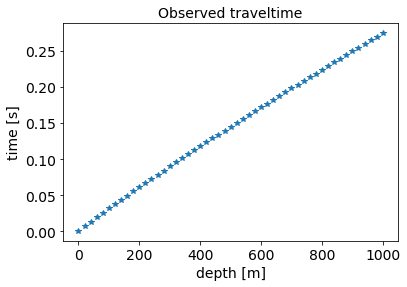

In [6]:
fig, ax = plt.subplots()
plt.plot(z[::desampling],data_true.getNdArray(),'*')
plt.xlabel("depth [m]")
plt.ylabel("time [s]")
_=plt.title("Observed traveltime")

In [7]:
#Create stopping criteria and related object
niter = 2000
Stop  = occamypy.BasicStopper(niter=niter)
#Create LCG solver
LCGsolver = occamypy.CG(Stop)
LCGsolver.setDefaults(save_obj=True) #Saving objective function within the solver

In [8]:
#Inital slowness model
model = model_true.clone().zero() #m = 0
VSP_prob = occamypy.LeastSquares(model.clone(), data_true, VSP_10)

In [9]:
LCGsolver.run(VSP_prob,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2020-12-07T23-49-31.908795/
	Modeling Operator:		Operator
##########################################################################################

iter = 0000, obj = 6.82008e-01, resnorm = 1.17e+00, gradnorm = 2.37e+02, feval = 2
iter = 0001, obj = 5.39592e-03, resnorm = 1.04e-01, gradnorm = 6.45e+00, feval = 4
iter = 0002, obj = 6.22682e-04, resnorm = 3.53e-02, gradnorm = 1.27e+00, feval = 6
iter = 0003, obj = 1.08804e-04, resnorm = 1.48e-02, gradnorm = 3.33e-01, feval = 8
iter = 0004, obj = 2.81691e-05, resnorm = 7.51e-03, gradnorm = 1.27e-01, feval = 10
iter = 0005, obj = 9.57360e-06, resnorm = 4.38e-03, gradnorm = 5.82e-02, feval = 12
iter = 0006, obj = 3.47089e-06, resnorm = 2.63e-03, gradnorm = 2.81e-02, feval = 14
iter = 0007, obj = 1.36467e-06, resnorm = 1.65e-03, gradnorm = 1.54e-02, feval = 16
iter = 0008, obj = 5.695

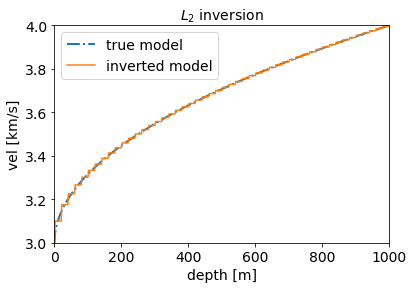

In [10]:
fig, ax = plt.subplots()
plt.plot(z,1.e-3*vel,label='true model',linewidth=2,linestyle='-.')
plt.plot(z,1.e-3/VSP_prob.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("$L_2$ inversion")

By looking at the objective function value, we clearly see that we can perfectly match the observed traveltime values. In fact, the problem is underdetermined (i.e., we have more model parameters than observations). Because of this fact, we can only retrieve the average velocity between observation depths. Moreover, we will encounter issues when random noise is present in the recorded data.

In [11]:
#Let's add some noise to the recorded data
noisy_data = data_true.clone()
noisy_data_arr = noisy_data.getNdArray()
noisy_data_arr += np.random.normal(scale=np.mean(noisy_data_arr)*0.005, size=noisy_data_arr.shape)

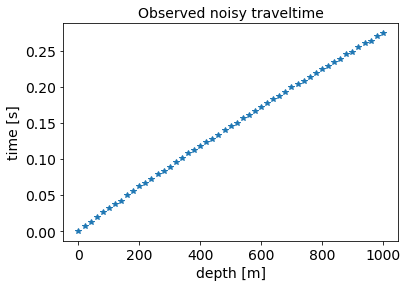

In [12]:
fig,ax=plt.subplots()
plt.plot(z[::desampling],noisy_data_arr,'*')
plt.xlabel("depth [m]")
plt.ylabel("time [s]")
_=plt.title("Observed noisy traveltime")

In [13]:
VSP_prob_noise = occamypy.LeastSquares(model.clone(),noisy_data,VSP_10)
LCGsolver.run(VSP_prob_noise,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2020-12-07T23-49-31.908795/
	Modeling Operator:		Operator
##########################################################################################

iter = 0000, obj = 6.82568e-01, resnorm = 1.17e+00, gradnorm = 2.37e+02, feval = 2
iter = 0001, obj = 5.37122e-03, resnorm = 1.04e-01, gradnorm = 6.43e+00, feval = 4
iter = 0002, obj = 6.27595e-04, resnorm = 3.54e-02, gradnorm = 1.26e+00, feval = 6
iter = 0003, obj = 1.18561e-04, resnorm = 1.54e-02, gradnorm = 3.38e-01, feval = 8
iter = 0004, obj = 3.44186e-05, resnorm = 8.30e-03, gradnorm = 1.33e-01, feval = 10
iter = 0005, obj = 1.42477e-05, resnorm = 5.34e-03, gradnorm = 5.93e-02, feval = 12
iter = 0006, obj = 7.85352e-06, resnorm = 3.96e-03, gradnorm = 3.23e-02, feval = 14
iter = 0007, obj = 4.59854e-06, resnorm = 3.03e-03, gradnorm = 2.21e-02, feval = 16
iter = 0008, obj = 2.721

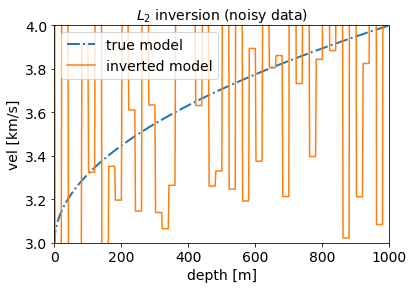

In [14]:
fig, ax = plt.subplots()
plt.plot(z,1.e-3*vel,label='true model',linewidth=2,linestyle='-.')
plt.plot(z,1.e-3/VSP_prob_noise.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("$L_2$ inversion (noisy data)")

A simple method to avoid these issues is to add prior knowledge to the inversion. In fact, we can change to problem to be solved and add a regularization term. We will test two kind of regularization: one in which a smooth constraint is added and another one where a prior model is assumed and employed in the regularization term.

In the first case, the objective function to be minimized is the following:
\begin{align}
\phi_{smooth}(\mathbf{m})=\frac{1}{2}\|G \mathbf{m} - \mathbf{d}_{obs} \|_2^2 + \frac{\epsilon^2}{2} \|D_1 \mathbf{m}\|_2^2,
\end{align}
where $\mathbf{m}$ represents the slowness model, $\mathbf{d}_{obs}$ is the observed traveltimes, while $G$ and $D_1$ are the modeling and a first-order derivative operators, respectively. The variable $\epsilon$ is the trade-off weight and is going to be set on the basis of trial and error.

In [15]:
#Instantiating regularization operator
D1 = occamypy.FirstDerivative(model_true, dz, stencil='forward')
#Instantiating regularized problem with noise-free data
VSP_prob_regD1 = occamypy.LeastSquaresRegularized(model.clone(),data_true,VSP_10,epsilon=1.0,reg_op=D1)
#Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_regD1.estimate_epsilon(True)
VSP_prob_regD1.epsilon = epsilon_balance * 1e-4

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 4.25e+04


In [16]:
LCGsolver.run(VSP_prob_regD1,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2020-12-07T23-49-31.908795/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 0000, obj = 6.82008e-01, resnorm = 1.17e+00, gradnorm = 2.37e+02, feval = 2
iter = 0001, obj = 5.39593e-03, resnorm = 1.04e-01, gradnorm = 6.45e+00, feval = 4
iter = 0002, obj = 6.22693e-04, resnorm = 3.53e-02, gradnorm = 1.27e+00, feval = 6
iter = 0003, obj = 1.08819e-04, resnorm = 1.48e-02, gradnorm = 3.33e-01, feval = 8
iter = 0004, obj = 2.81852e-05, resnorm = 7.51e-03, gradnorm = 1.27e-01, feval = 10
iter = 0005, obj = 9.58737e-06, resnorm = 4.38e-03, gradnorm = 5.82e-02, feval = 12
iter = 0006, obj = 3.47967e-06, resnorm = 2.64e-03, gradnorm = 2.82e-02, feval = 14
iter = 0007, obj = 1.36739e-06, resnorm = 1.65e-03, gradnorm = 1.54e-02, feval = 16
iter = 0008, obj = 5.678

iter = 0137, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 4.08e-10, feval = 276
iter = 0138, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 6.23e-10, feval = 278
iter = 0139, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 6.28e-10, feval = 280
iter = 0140, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 6.63e-10, feval = 282
iter = 0141, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 2.28e-09, feval = 284
iter = 0142, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 6.23e-10, feval = 286
iter = 0143, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 3.21e-10, feval = 288
iter = 0144, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 5.98e-10, feval = 290
iter = 0145, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 9.29e-10, feval = 292
iter = 0146, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 2.88e-10, feval = 294
iter = 0147, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 1.79e-10, feval = 296
iter = 0148, obj = 8.41318e-11, resnorm = 1.30e-05, gradnorm = 3.

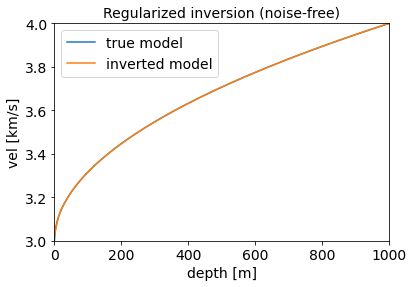

In [17]:
fig,ax=plt.subplots()
plt.plot(z,1.e-3*vel,label='true model')
plt.plot(z,1.e-3/VSP_prob_regD1.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("Regularized inversion (noise-free)")

In [18]:
#Instantiating regularized problem with noisy data
VSP_prob_regD1 = occamypy.LeastSquaresRegularized(model.clone(),noisy_data,VSP_10,epsilon=1.0,reg_op=D1)
#Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_regD1.estimate_epsilon(True)
VSP_prob_regD1.epsilon = epsilon_balance * 5e-2

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 4.25e+04


In [19]:
LCGsolver.run(VSP_prob_regD1,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2020-12-07T23-49-31.908795/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 0000, obj = 6.82568e-01, resnorm = 1.17e+00, gradnorm = 2.37e+02, feval = 2
iter = 0001, obj = 7.05999e-03, resnorm = 1.19e-01, gradnorm = 8.75e+01, feval = 4
iter = 0002, obj = 5.92288e-03, resnorm = 1.09e-01, gradnorm = 3.00e+01, feval = 6
iter = 0003, obj = 5.67245e-03, resnorm = 1.07e-01, gradnorm = 1.96e+01, feval = 8
iter = 0004, obj = 5.53608e-03, resnorm = 1.05e-01, gradnorm = 1.64e+01, feval = 10
iter = 0005, obj = 5.42369e-03, resnorm = 1.04e-01, gradnorm = 1.60e+01, feval = 12
iter = 0006, obj = 5.35725e-03, resnorm = 1.04e-01, gradnorm = 8.83e+00, feval = 14
iter = 0007, obj = 4.74845e-03, resnorm = 9.75e-02, gradnorm = 4.84e+01, feval = 16
iter = 0008, obj = 3.397

iter = 0138, obj = 1.42558e-05, resnorm = 5.34e-03, gradnorm = 1.49e-01, feval = 278
iter = 0139, obj = 1.42464e-05, resnorm = 5.34e-03, gradnorm = 1.43e-01, feval = 280
iter = 0140, obj = 1.42377e-05, resnorm = 5.34e-03, gradnorm = 1.38e-01, feval = 282
iter = 0141, obj = 1.42292e-05, resnorm = 5.33e-03, gradnorm = 1.39e-01, feval = 284
iter = 0142, obj = 1.42208e-05, resnorm = 5.33e-03, gradnorm = 1.37e-01, feval = 286
iter = 0143, obj = 1.42128e-05, resnorm = 5.33e-03, gradnorm = 1.34e-01, feval = 288
iter = 0144, obj = 1.42050e-05, resnorm = 5.33e-03, gradnorm = 1.31e-01, feval = 290
iter = 0145, obj = 1.41976e-05, resnorm = 5.33e-03, gradnorm = 1.28e-01, feval = 292
iter = 0146, obj = 1.41906e-05, resnorm = 5.33e-03, gradnorm = 1.25e-01, feval = 294
iter = 0147, obj = 1.41838e-05, resnorm = 5.33e-03, gradnorm = 1.23e-01, feval = 296
iter = 0148, obj = 1.41773e-05, resnorm = 5.32e-03, gradnorm = 1.20e-01, feval = 298
iter = 0149, obj = 1.41710e-05, resnorm = 5.32e-03, gradnorm = 1.

iter = 0275, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.95e-03, feval = 552
iter = 0276, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.90e-03, feval = 554
iter = 0277, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.80e-03, feval = 556
iter = 0278, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.72e-03, feval = 558
iter = 0279, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.62e-03, feval = 560
iter = 0280, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.53e-03, feval = 562
iter = 0281, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.45e-03, feval = 564
iter = 0282, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.42e-03, feval = 566
iter = 0283, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.36e-03, feval = 568
iter = 0284, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.30e-03, feval = 570
iter = 0285, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.23e-03, feval = 572
iter = 0286, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 1.

iter = 0413, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 4.32e-06, feval = 828
iter = 0414, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 4.15e-06, feval = 830
iter = 0415, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 4.04e-06, feval = 832
iter = 0416, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 4.03e-06, feval = 834
iter = 0417, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 3.70e-06, feval = 836
iter = 0418, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 3.55e-06, feval = 838
iter = 0419, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 3.40e-06, feval = 840
iter = 0420, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 3.26e-06, feval = 842
iter = 0421, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 3.20e-06, feval = 844
iter = 0422, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 3.03e-06, feval = 846
iter = 0423, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 2.94e-06, feval = 848
iter = 0424, obj = 1.40506e-05, resnorm = 5.30e-03, gradnorm = 2.

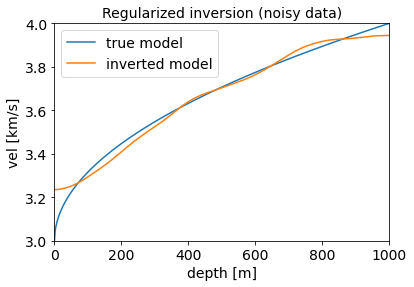

In [20]:
fig,ax=plt.subplots()
plt.plot(z,1.e-3*vel,label='true model')
plt.plot(z,1.e-3/VSP_prob_regD1.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("Regularized inversion (noisy data)")

In the second case (i.e., when a prior model is employed), the objective function to be minimized is written as follows:
\begin{align}
\phi_{smooth}(\mathbf{m})=\frac{1}{2}\|G \mathbf{m} - \mathbf{d}_{obs} \|_2^2 + \frac{\epsilon^2}{2} \|\mathbf{m} - \mathbf{m}_{prior}\|_2^2,
\end{align}
where $\mathbf{m}_{prior}$ is the prior model vector expressed as the following velocity profile:
\begin{align}
v_{prior}(z)  = 3100.+ 1.0 z
\end{align}

In [22]:
vel_prior = 3100.0 + z
model_prior = occamypy.VectorNumpy(1.0/vel_prior)

In [23]:
#Instantiating regularized problem with prior model and noisy data
VSP_prob_prior = occamypy.LeastSquaresRegularized(model.clone(),noisy_data,VSP_10,epsilon=1.0,prior_model=model_prior)
#Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_prior.estimate_epsilon(True)
VSP_prob_prior.epsilon = epsilon_balance * 2.5e-1

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 2.04e+02


In [24]:
LCGsolver.run(VSP_prob_prior,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2020-12-07T23-49-31.908795/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 0000, obj = 7.33663e-01, resnorm = 1.21e+00, gradnorm = 2.52e+02, feval = 2
iter = 0001, obj = 9.82969e-03, resnorm = 1.40e-01, gradnorm = 1.06e+01, feval = 4
iter = 0002, obj = 9.64246e-04, resnorm = 4.39e-02, gradnorm = 2.66e+00, feval = 6
iter = 0003, obj = 7.89365e-05, resnorm = 1.26e-02, gradnorm = 4.98e-01, feval = 8
iter = 0004, obj = 4.32009e-05, resnorm = 9.30e-03, gradnorm = 5.48e-02, feval = 10
iter = 0005, obj = 4.27284e-05, resnorm = 9.24e-03, gradnorm = 4.50e-03, feval = 12
iter = 0006, obj = 4.27250e-05, resnorm = 9.24e-03, gradnorm = 2.75e-04, feval = 14
iter = 0007, obj = 4.27250e-05, resnorm = 9.24e-03, gradnorm = 1.23e-05, feval = 16
iter = 0008, obj = 4.272

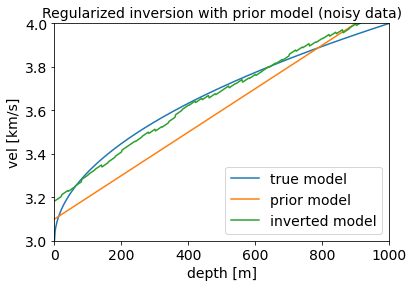

In [25]:
fig,ax=plt.subplots()
plt.plot(z,1.e-3*vel,label='true model')
plt.plot(z,1.e-3*vel_prior,label='prior model')
plt.plot(z,1.e-3/VSP_prob_prior.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("Regularized inversion with prior model (noisy data)")